# Black-Scholes model study

Let us introduce the Black-Scholes model : 

$dS_t = rS_t dt + \sigma S_t dW_t $

Given the **Euler-Maruyama Approximation** :

$S_{t+\Delta t} =S_t + r S_t dt + \sigma S_t \sqrt{dt} Z$

With $Z \sim \mathcal{N}(0,1)$

Let us code this model via Python :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sk

In [80]:
S0 = 1000
r = .08
sigma = .4
T = 1
N = 365
M = 100
dt = T/N

S = np.zeros((M, N+1))
S[:,0]=S0

for t in range(1, N+1):
    Z = np.random.standard_normal(M)
    S[:, t] = S[:, t-1] + r * S[:, t-1]*dt + sigma * S[:, t-1] * np.sqrt(dt) * Z

In [81]:
ST = S[:, -1]
K = 1000

call_price= np.exp(-r*T)*np.mean(np.maximum(ST-K, 0))
put_price = np.exp(-r*T)*np.mean(np.maximum(K-ST, 0))
diff = call_price - put_price
print(f"Simulated European Call price : {call_price}")
print(f"Simulated European Put price : {put_price}")
print(f"Call-Put difference : {diff} ")

Simulated European Call price : 176.99414444976748
Simulated European Put price : 136.53295118562366
Call-Put difference : 40.461193264143816 


## Visualization of 100 simulated paths using the Black-Scholes model 

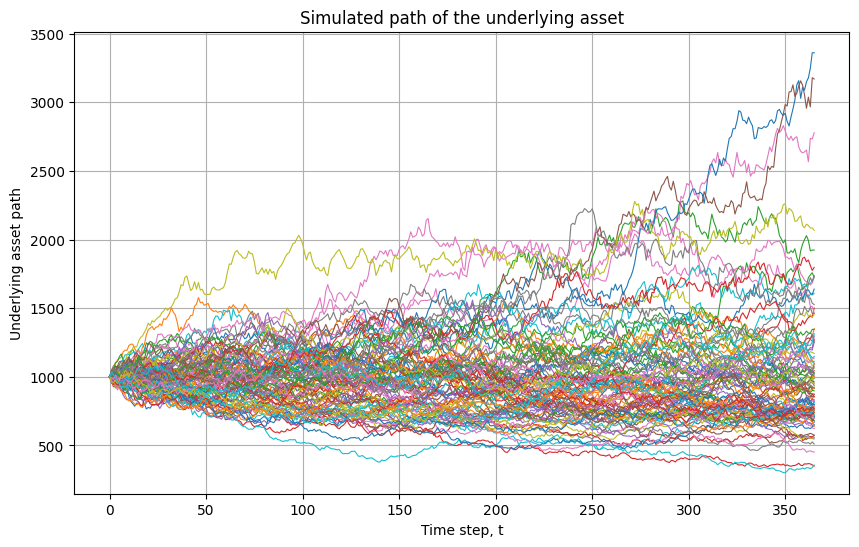

In [82]:
plt.figure(figsize=(10,6))
for i in range(M):
    plt.plot(S[i], lw = 0.8)
plt.title("Simulated path of the underlying asset")
plt.xlabel("Time step, t")
plt.ylabel("Underlying asset path")
plt.grid(True)
plt.show()

Let us visualize the **average of all simulated paths**

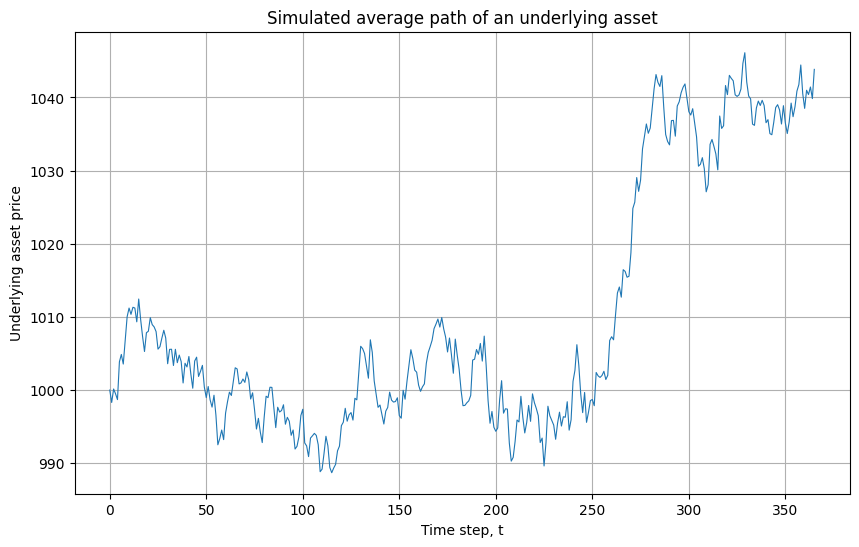

In [85]:
plt.figure(figsize=(10,6))
plt.plot(np.mean(S, axis=0), lw = 0.8)
plt.title("Simulated average path of an underlying asset")
plt.xlabel("Time step, t")
plt.ylabel("Underlying asset price")
plt.grid(True)
plt.show()

## Visualization of call and put option prices as functions of volatility ($\sigma$), time to maturity ($T$), and the risk-free interest rate ($r$).

The analytical price of a European call/put is :

Defining $d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)T}{\sigma \sqrt{T}}$ et $d_2 = d_1 - \sigma \sqrt{T}$

$C(S_0, K, T, r, \sigma)= S_0\Phi(d_1) - Ke^{-rT}\Phi(d_2)$

$P(S_0, K, T, r, \sigma) = Ke^{-rT}\Phi(-d_2) - S_0\Phi(-d_1)$

### Let’s visualize the option prices as a function of volatility ($\sigma$).

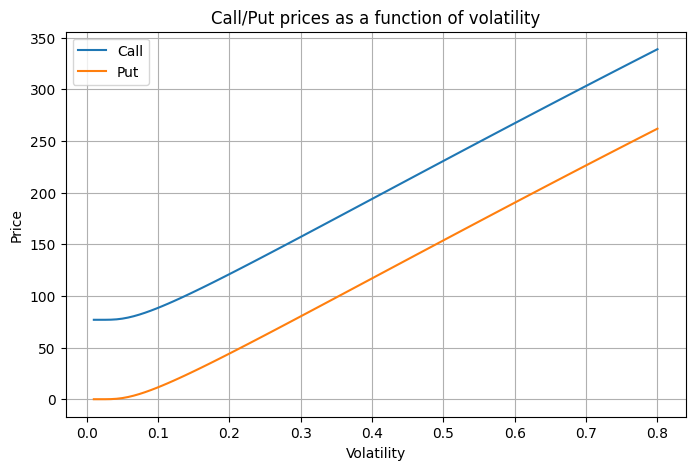

In [86]:
def b_s_call(Sc,Kc,Tc,rc,sc):
    d1=(np.log(Sc/Kc) + (rc + 0.5 * sc**2)*Tc)/ (sc * np.sqrt(Tc))
    d2 = d1 - sc*np.sqrt(Tc)
    return Sc*sk.norm.cdf(d1) - Kc* np.exp(-rc*Tc) * sk.norm.cdf(d2)

def b_s_put(Sp,Kp,Tp,rp,sp):
    d1=(np.log(Sp/Kp) + (rp + 0.5 * sp**2)*Tp)/ (sp* np.sqrt(Tp))
    d2 = d1 - sp*np.sqrt(Tp)
    return -Sp*sk.norm.cdf(-d1) + Kp * np.exp(-rp*Tp) * sk.norm.cdf(-d2)

s= np.linspace(0.01, 0.8, 100)
S0 = 1000
r = .08
T = 1
K=1000

call_prices_sigma = [b_s_call(S0, K, T, r, sc) for sc in s ]
put_prices_sigma = [b_s_put(S0, K, T, r, sp) for sp in s ]

plt.figure(figsize=(8,5))
plt.plot(s, call_prices_sigma, label="Call")
plt.title("Call/Put prices as a function of volatility")
plt.plot(s, put_prices_sigma, label="Put")
plt.xlabel("Volatility")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

Nous constatons que **les prix d'un call et d'un put augmentent avec la volatilité**

### Visualisation des prix Call/Put en fonction du taux sans risque

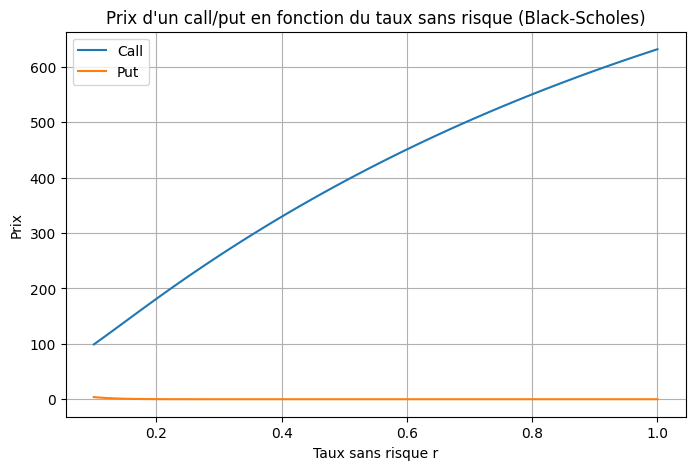

In [33]:
r = np.linspace(0.1, 1, 100)
S0 = 1000
T = 1
K=1000
s = .08
call_prices_risk = [b_s_call(S0, K, T, r_i, s) for r_i in r]
put_prices_risk = [b_s_put(S0, K, T, r_i, s) for r_i in r]

plt.figure(figsize=(8,5))
plt.plot(r1, call_prices_risk, label="Call")
plt.plot(r1, put_prices_risk, label="Put")
plt.title("Prix d'un call/put en fonction du taux sans risque (Black-Scholes)")
plt.xlabel("Taux sans risque r")
plt.ylabel("Prix")
plt.grid(True)
plt.legend()
plt.show()

Nous constatons que **le prix d'un call augmente avec le taux sans risque. Celui d'un put diminue**

### Visualisation des prix Call/Put en fonction de l'écheance

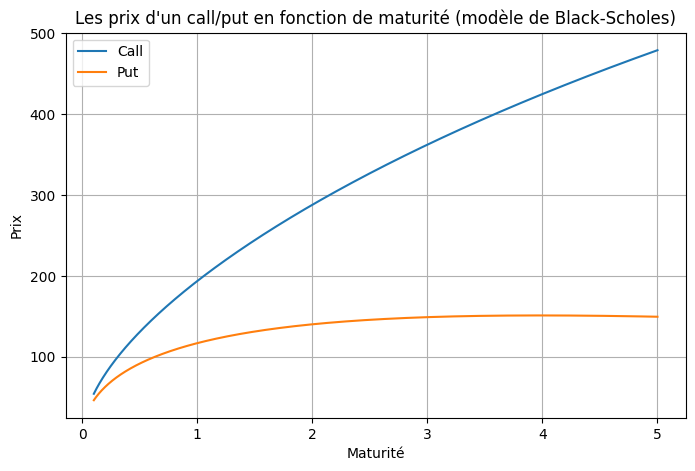

In [34]:
T= np.linspace(0.1, 5, 1000)
S0 = 1000
r = .08
s= .7
K=1000
call_prices_time = [b_s_call(S0, K, T1, r, sigma) for T1 in T ]
put_prices_time = [b_s_put(S0, K, T1, r, sigma) for T1 in T ]

plt.figure(figsize=(8,5))
plt.plot(T, call_prices_time, label="Call")
plt.title("Les prix d'un call/put en fonction de maturité (modèle de Black-Scholes)")
plt.plot(T, put_prices_time, label="Put")
plt.xlabel("Maturité")
plt.ylabel("Prix")
plt.grid(True)
plt.legend()
plt.show()

Nous témoignons que **le prix d'un call augmente avec la maturité. Celui d'un put aussi**

# Etude des Grecques

## 1. $\Delta$

La Grecque $\Delta$ se définit comme : $\Delta = \frac{\partial V}{\partial S}$, $V$ - prix de l'option

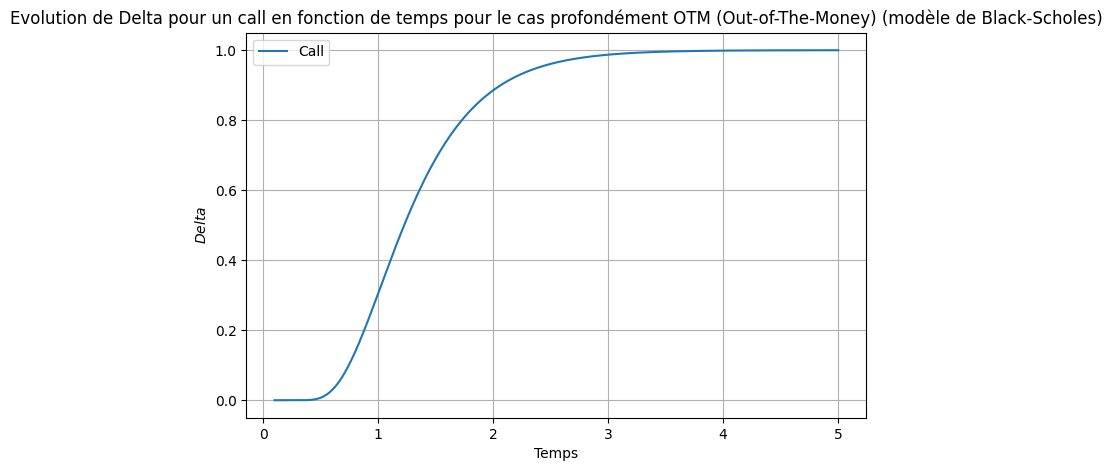

In [69]:
def delta_call(S_, K_, T_, r_, s_):
    h=0.001
    return (b_s_call(S_+h,K_, T_, r_, s_ ) - b_s_call(S_, K_, T_, r_, s_))/h

def delta_put(S_, K_, T_, r_, s_):
    h=0.001
    return (b_s_put(S_+h,K_, T_, r_, s_ ) - b_s_put(S_, K_, T_, r_, s_))/h

Td= np.linspace(0.1, 250, 1000)
S0=1
K=1000
sigma = .4
r = .04
delta_time_call=[delta_call(S0, K, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(T, delta_time_call, label="Call")
plt.title(f"Evolution de Delta pour un call en fonction de temps pour le cas profondément OTM (Out-of-The-Money) (modèle de Black-Scholes)")
plt.xlabel("Temps")
plt.ylabel("$Delta$")
plt.grid(True)
plt.legend()
plt.show()

Nous constatons que **le $\Delta_{Call}$ pour le cas OTM profond ($S_0 << K$) augmente légèrement avec la maturité**. Ainsi **Le prix du sous-jacent suit la même monotonie que le prix d'une option (Si le prix du sous-jacent augmente, celui d'un call aussi)**.

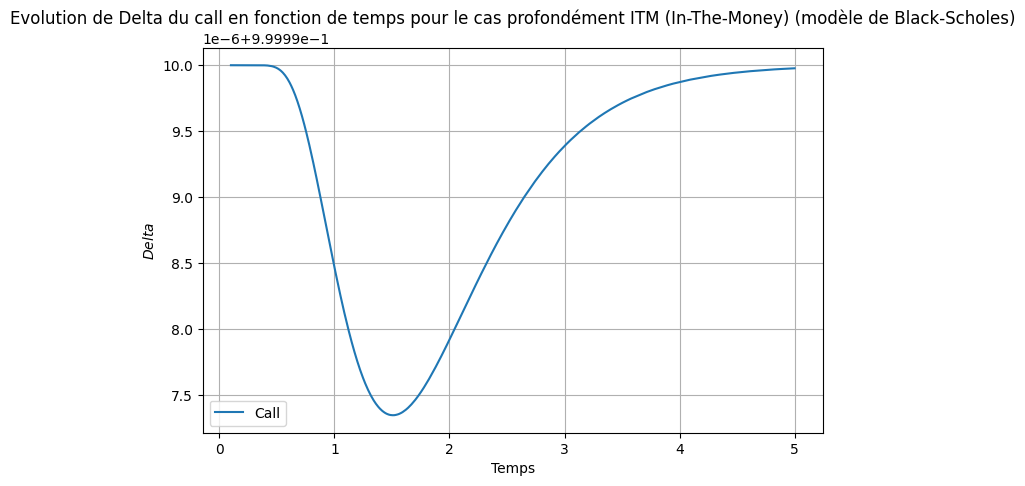

In [68]:
Td= np.linspace(0.1, 200, 1000)
S0=1000
K=1
sigma = .4
r = .04
delta_time_call=[delta_call(S0, K, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(T, delta_time_call, label="Call")
plt.title(f"Evolution de Delta du call en fonction de temps pour le cas profondément ITM (In-The-Money) (modèle de Black-Scholes)")
plt.xlabel("Temps")
plt.ylabel("$Delta$")
plt.grid(True)
plt.legend()
plt.show()

Nous constatons que **le $\Delta_{Call}$ pour le cas ITM profond ($S_0 >> K$) reste quasiment constante (car la "vague" observée est due à un artefact numérique)**

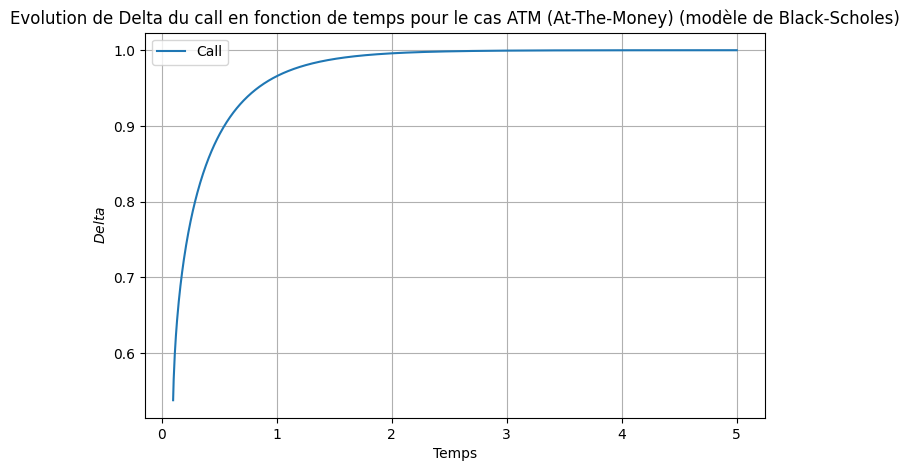

In [67]:
Td= np.linspace(0.1, 200, 1000)
S0=1000
K=1000
sigma = .4
r = .04
delta_time_call=[delta_call(S0, K, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(T, delta_time_call, label="Call")
plt.title(f"Evolution de Delta du call en fonction de temps pour le cas ATM (At-The-Money) (modèle de Black-Scholes)")
plt.xlabel("Temps")
plt.ylabel("$Delta$")
plt.grid(True)
plt.legend()
plt.show()

Nous constatons que dans le cas **ATM, $\Delta_{Call}$ augmente avec la maturité**

Dans tous les trois cas : 

> Le prix d'une option CALL suit la même dynamique ou reste constant (cas ITM) par rapport au prix de sous-jacent. 

## $\Delta$ du put

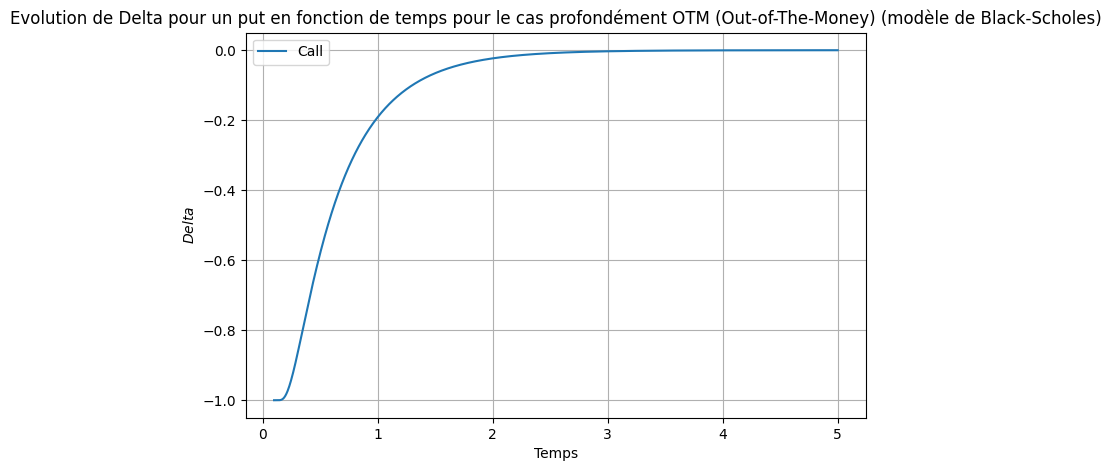

In [70]:
Td= np.linspace(0.1, 200, 1000)
S0=100
K=1000
sigma = .4
r = .04
delta_time_put=[delta_put(S0, K, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(T, delta_time_put, label="Call")
plt.title(f"Evolution de Delta pour un put en fonction de temps pour le cas profondément OTM (Out-of-The-Money) (modèle de Black-Scholes)")
plt.xlabel("Temps")
plt.ylabel("$Delta$")
plt.grid(True)
plt.legend()
plt.show()

Nous constatons que **$\Delta_{Put}$ augmente avec le temps de maturité, mais reste négatif** 

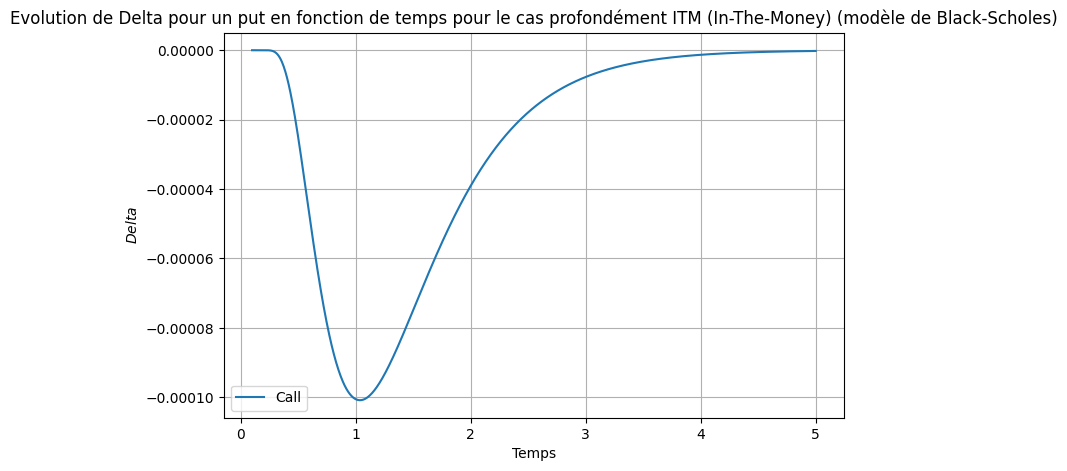

In [71]:
Td= np.linspace(0.1, 200, 1000)
S0=10000
K=100
sigma = .4
r = .04
delta_time_put=[delta_put(S0, K, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(T, delta_time_put, label="Call")
plt.title(f"Evolution de Delta pour un put en fonction de temps pour le cas profondément ITM (In-The-Money) (modèle de Black-Scholes)")
plt.xlabel("Temps")
plt.ylabel("$Delta$")
plt.grid(True)
plt.legend()
plt.show()

Nous constatons que **$\Delta_{Put}$ reste quasiment constant et nul avec le temps de maturité** 

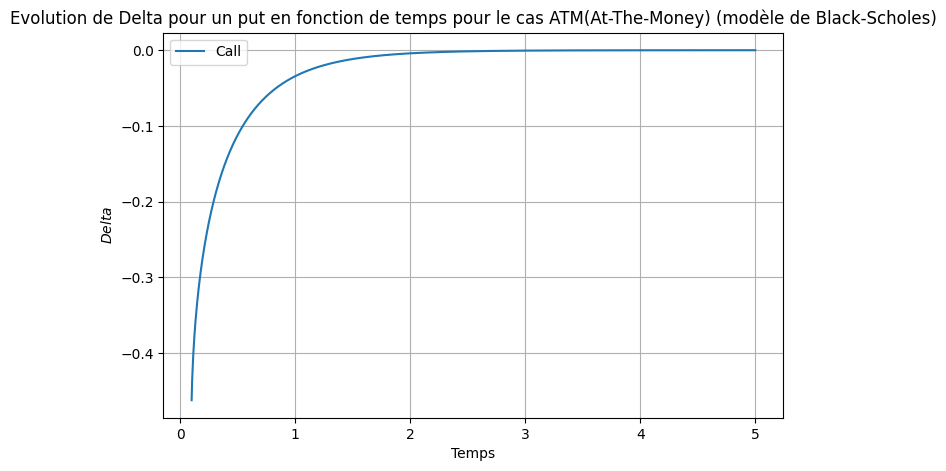

In [72]:
Td= np.linspace(0.1, 200, 1000)
S0=1000
K=1000
sigma = .4
r = .04
delta_time_put=[delta_put(S0, K, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(T, delta_time_put, label="Call")
plt.title(f"Evolution de Delta pour un put en fonction de temps pour le cas ATM(At-The-Money) (modèle de Black-Scholes)")
plt.xlabel("Temps")
plt.ylabel("$Delta$")
plt.grid(True)
plt.legend()
plt.show()

Nous constatons que **$\Delta_{Put}$ augmente avec le temps de maturité, mais reste négatif** 

> Dans tous les trois cas, nous avons constaté que le prix d'une option Put suit la dynamique inverse par rapport au prix de son/ses sous-jacents. ($\Delta$ < 0)

# 2. Vega ($\nu$)

La Grecque $\nu$ se définit comme : $\nu$ = $\frac{\partial V}{\partial \sigma}$, $V$ - prix de l'option

Le **calcul de $\nu$ d'un put et d'un call est le même**

In [75]:
def vega(S_, K_, T_, r_, s_):
    h=0.001
    return (b_s_call(S_,K_, T_, r_, s_+h ) - b_s_call(S_, K_, T_, r_, s_))/h


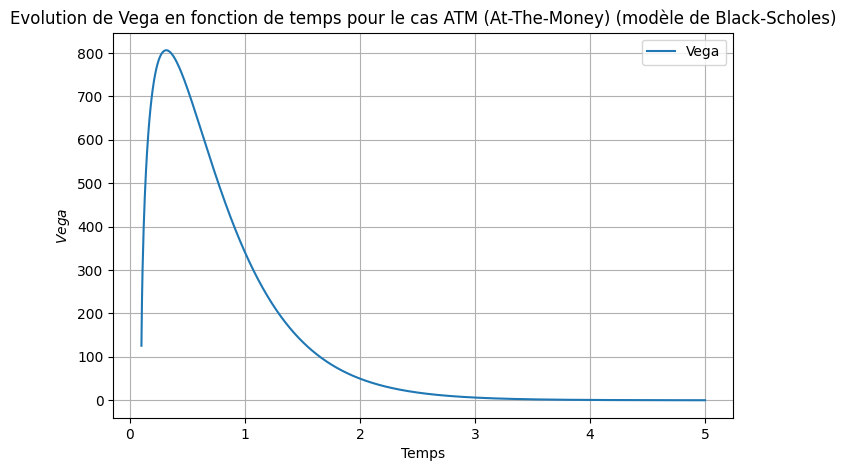

In [78]:
Td= np.linspace(0.1, 250, 1000)
S0=1000
K=1000
sigma = .4
r = .04
vega_time=[vega(S0, K, t, r, sigma) for t in Td]
plt.figure(figsize=(8,5))
plt.plot(T, vega_time, label="Vega")
plt.title(f"Evolution de Vega en fonction de temps pour le cas ATM (At-The-Money) (modèle de Black-Scholes)")
plt.xlabel("Temps")
plt.ylabel("$Vega$")
plt.grid(True)
plt.legend()
plt.show()

**Nous constatons que $\nu$ tend vers 0 avec la variation de la maturité**